In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [3]:
!pip install plotly

In [4]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split

In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
train_data = train_df('D:\Mahir\Datasets\Merged Dataset 2\Training')

In [8]:
train_data


,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
1,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
2,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
3,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
4,D:\Mahir\Datasets\Merged Dataset 2\Training\gl...,glioma
...,...,...
16983,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary
16984,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary
16985,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary
16986,D:\Mahir\Datasets\Merged Dataset 2\Training\pi...,pituitary


In [9]:
test_data = test_df('D:\Mahir\Datasets\Merged Dataset 2\Testing')

In [10]:
test_data

,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
1,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
2,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
3,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
4,D:\Mahir\Datasets\Merged Dataset 2\Testing\gli...,glioma
...,...,...
4322,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary
4323,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary
4324,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary
4325,D:\Mahir\Datasets\Merged Dataset 2\Testing\pit...,pituitary


In [11]:
train_path = 'D:\Mahir\Datasets\Merged Dataset 2\Training'
test_path = 'D:\Mahir\Datasets\Merged Dataset 2\Testing'

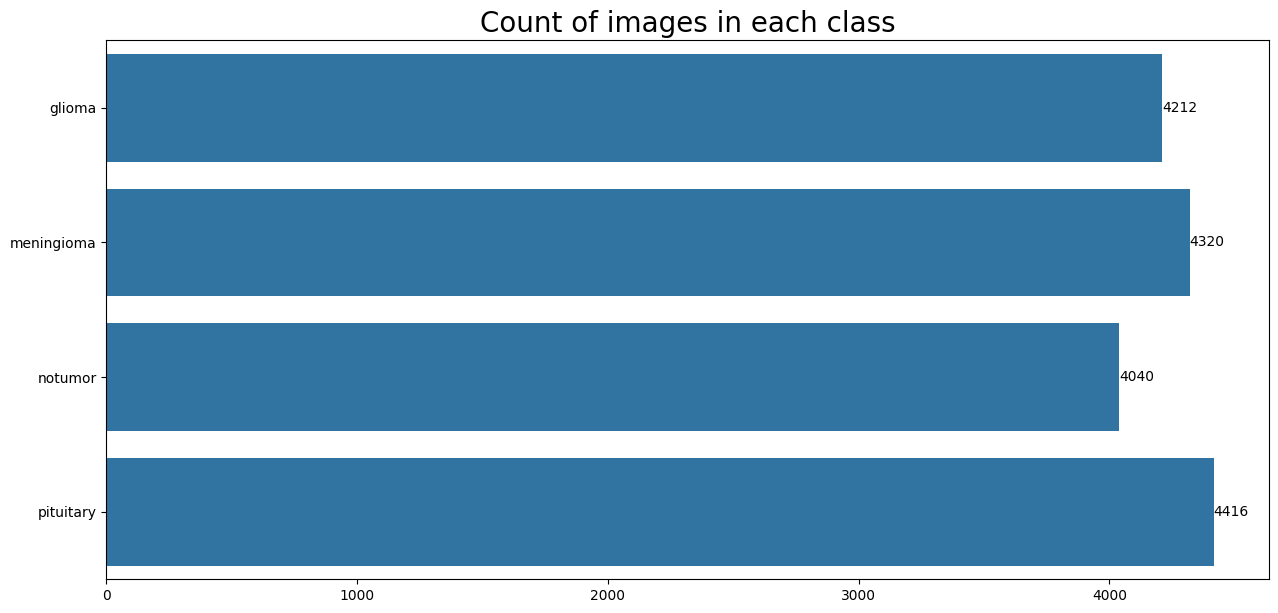

In [12]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_data , y=train_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

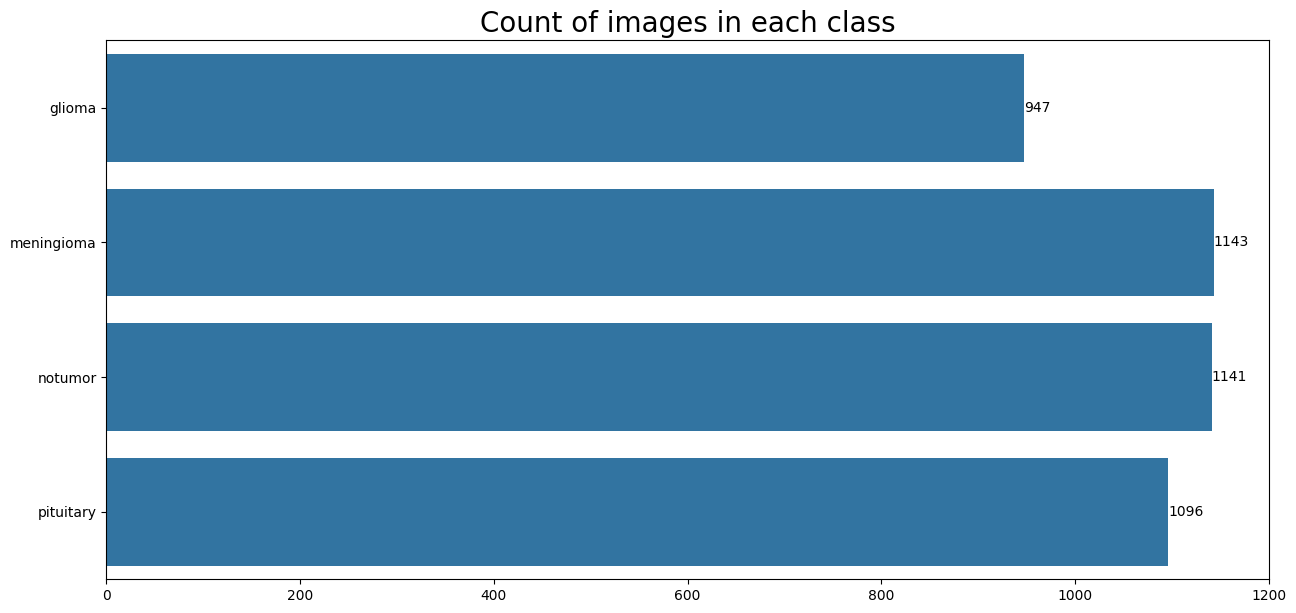

In [13]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_data , y=test_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()


In [14]:
# Image size
image_size = (160, 160)

# Training batch size
batch_size = 32

In [15]:
# Data preprocessing without any augmentation, only rescaling and validation split
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(160, 160),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Creating validation data generator
val_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='validation',
                                                 shuffle=False,
                                                  seed=0)

# Applying the generator to testing data, only rescaling
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='training', 
                                                  shuffle=False)

Found 16988 images belonging to 4 classes.
Found 2162 images belonging to 4 classes.
Found 2165 images belonging to 4 classes.


In [16]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

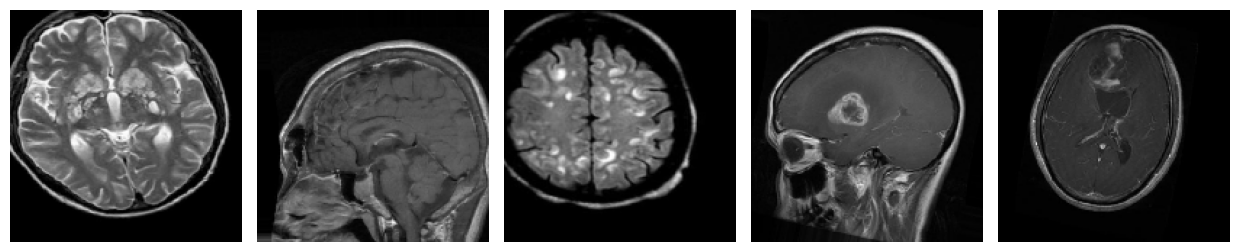

In [17]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)


In [18]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (160, 160, 3)
Batch size: 32
Number of Train batches: 531
Number of Validation batches: 68
Number of Testing batches: 68


In [19]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [20]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

In [30]:
import time
from tensorflow.keras.models import load_model

import time
from tensorflow.keras.models import load_model

def evaluate_models_with_batch_sizes(model_paths, test_generator, batch_sizes):
    """
    Evaluate models with different batch sizes and measure inference time.

    Parameters:
        model_paths (dict): Dictionary of model names and paths.
        test_generator (object): Test data generator.
        batch_sizes (list): List of batch sizes to test.

    Returns:
        results (dict): Evaluation results for each model and batch size.
    """
    results = {}

    for model_name, model_path in model_paths.items():
        print(f"\nEvaluating model: {model_name}")

        # Load the model
        model = load_model(model_path)

        for batch_size in batch_sizes:
            print(f"\nTesting with batch size: {batch_size}")

            # Adjust batch size in the test generator
            test_generator.batch_size = batch_size
            test_generator.reset()

            # GPU warm-up
            dummy_data = next(test_generator)[0]
            _ = model.predict(dummy_data)

            # Measure inference time
            print("Measuring inference time...")
            start_time = time.time()
            predictions = model.predict(test_generator, verbose=0)
            end_time = time.time()

            total_time = end_time - start_time
            num_samples = len(test_generator.filenames)
            avg_time_per_image = total_time / num_samples

            # Evaluate the model
            test_generator.reset()
            test_score = model.evaluate(test_generator, verbose=1)

            # Store the results
            if model_name not in results:
                results[model_name] = {}

            results[model_name][f"Batch Size {batch_size}"] = {
                "Total Inference Time (s)": round(total_time, 4),
                "Average Time per Image (s)": round(avg_time_per_image, 4),
                "Test Loss": round(test_score[0], 4),
                "Test Accuracy (%)": round(test_score[1] * 100, 2)
            }

            print(f"Batch Size {batch_size} - Total Time: {total_time:.4f}s, "
                  f"Average Time per Image: {avg_time_per_image:.4f}s, "
                  f"Test Loss: {test_score[0]:.4f}, "
                  f"Test Accuracy: {test_score[1] * 100:.2f}%")

    return results



model_paths = {
    "VGG": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Teachers\\VGG16_Teacher_2_D2.h5",
    "Xception": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Teachers\\Xception_Teacher_2_D2.h5",
    "Tiny Resnet wout KD": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Students wout KD\\Tiny_Resnet_D2.h5",
    "Tiny Xception wout KD": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Students wout KD\\Tiny_Xception_D2.h5",
    "Tiny Densenet wout KD": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Students wout KD\\Tiny_Densenet_D2.h5",
    "Tiny Resnet Teacher VGG": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Single teacher Single Student\\VGG Teacher\\checkpoints_and_history\\VGG_Resnet_d2.h5",
    "Tiny Xception Teacher VGG": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Single teacher Single Student\\VGG Teacher\\checkpoints_and_history\\VGG_xception_d2.h5",
    "Tiny Densenet Teacher VGG": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Single teacher Single Student\\VGG Teacher\\checkpoints_and_history\\VGG_Densenet_d2.h5",
    "Tiny Resnet Teacher Xception": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Single teacher Single Student\\\Xception Teacher\\checkpoints_and_history\\xcep_resnet_d2.h5",
    "Tiny Xception Teacher Xception": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Single teacher Single Student\\\Xception Teacher\\checkpoints_and_history\\xcep_xception_d2.h5",
    "Tiny Densenet Teacher Xception": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Single teacher Single Student\\\Xception Teacher\\checkpoints_and_history\\xcep_densenet_d2.h5",
    "Tiny Resnet MTKD": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Multi Teacher Single Student\\d2\\Tiny Resnet\\Multi_Resnet_d2.h5",
    "Tiny Xception MTKD": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Multi Teacher Single Student\\d2\\Tiny Xception\\Multi_Xception_d2.h5",
    "Tiny Densenet MTKD": "D:\\Mahir\\Brain\\Brain-Tumor-Classification-Research\\Final Experiments\\Multi Teacher Single Student\\d2\\Tiny Densenet\\Multi_Densenet_d2.h5"
}
# Example usage
batch_sizes = [1, 4, 8, 16, 32]
evaluation_results = evaluate_models_with_batch_sizes(model_paths, test_generator, batch_sizes)

# Print the summary
for model_name, batch_results in evaluation_results.items():
    print(f"\nFinal Summary for {model_name}:")
    for batch, metrics in batch_results.items():
        print(f"{batch}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value}")





Evaluating model: VGG

Testing with batch size: 1
1/1 [==============================] - 1s 608ms/step
Measuring inference time...
2165/2165 [==============================] - 14s 6ms/step - loss: 0.1422 - accuracy: 0.9727 - precision: 0.9745 - recall: 0.9714
Batch Size 1 - Total Time: 12.2598s, Average Time per Image: 0.0057s, Test Loss: 0.1422, Test Accuracy: 97.27%

Testing with batch size: 4
1/1 [==============================] - 1s 733ms/step
Measuring inference time...
542/542 [==============================] - 7s 12ms/step - loss: 0.1422 - accuracy: 0.9727 - precision: 0.9745 - recall: 0.9714
Batch Size 4 - Total Time: 6.1277s, Average Time per Image: 0.0028s, Test Loss: 0.1422, Test Accuracy: 97.27%

Testing with batch size: 8
1/1 [==============================] - 1s 962ms/step
Measuring inference time...
271/271 [==============================] - 5s 20ms/step - loss: 0.1422 - accuracy: 0.9727 - precision: 0.9745 - recall: 0.9714
Batch Size 8 - Total Time: 6.0784s, Average Ti

In [31]:
import pandas as pd

# Define the desired order of model names
model_order = [
    "VGG",
    "Xception",
    "Tiny Resnet wout KD",
    "Tiny Xception wout KD",
    "Tiny Densenet wout KD",
    "Tiny Resnet Teacher VGG",
    "Tiny Xception Teacher VGG",
    "Tiny Densenet Teacher VGG",
    "Tiny Resnet Teacher Xception",
    "Tiny Xception Teacher Xception",
    "Tiny Densenet Teacher Xception",
    "Tiny Resnet MTKD",
    "Tiny Xception MTKD",
    "Tiny Densenet MTKD"
]

# Flatten the nested dictionary into a list of dictionaries (example data assumed)
flattened_results = []

for model_name, batch_results in evaluation_results.items():
    for batch, metrics in batch_results.items():
        row = {"Model": model_name, "Batch Size": batch}
        row.update(metrics)
        flattened_results.append(row)

# Create a DataFrame
results_df = pd.DataFrame(flattened_results)

# Ensure "Batch Size" is numeric for proper sorting
results_df["Batch Size"] = results_df["Batch Size"].str.extract(r'(\d+)').astype(int)

# Set "Model" as a categorical column with the specified order
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)

# Sort by "Batch Size" (ascending) and then by "Model" (using the specified order)
results_df = results_df.sort_values(by=["Batch Size", "Model"], ascending=[True, True])

# Display the DataFrame
print("\nEvaluation Summary (Sorted by Batch Size and Consistent Model Order):")
print(results_df.to_string(index=False, float_format="%.4f"))

# Optional: Save the results to a CSV file
# results_df.to_csv("evaluation_results_summary.csv", index=False)
# print("\nResults saved to 'evaluation_results_summary.csv'.")



Evaluation Summary (Sorted by Batch Size and Consistent Model Order):
                         Model  Batch Size  Total Inference Time (s)  Average Time per Image (s)  Test Loss  Test Accuracy (%)
                           VGG           1                   12.2598                      0.0057     0.1422            97.2700
                      Xception           1                   12.7837                      0.0059     0.1662            97.3200
           Tiny Resnet wout KD           1                    7.2077                      0.0033     0.4524            91.2200
         Tiny Xception wout KD           1                    5.8763                      0.0027     0.3021            91.7300
         Tiny Densenet wout KD           1                   11.1809                      0.0052     0.7242            79.3500
       Tiny Resnet Teacher VGG           1                    7.1228                      0.0033     2.4358            94.8700
     Tiny Xception Teacher VGG          